In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import json,os
import pandas as pd

from plot import create_dual_axis_plots, create_dual_axis_plots_for_indices

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

custom_palette = [
    (97/255, 108/255, 140/255),   # Dark grayish blue
    (86/255, 140/255, 135/255),   # Teal green
    (178/255, 213/255, 155/255),  # Light green
    (242/255, 222/255, 121/255),  # Light yellow
    (217/255, 95/255, 24/255)     # Orange red
]

custom_palette_2 = [
    (0.749, 0.294, 0.196),  # Red-orange
    (0.851, 0.373, 0.094),  # Orange
    (0.961, 0.765, 0.392),  # Yellow-orange
    (0.949, 0.871, 0.475),  # Light yellow
    (0.698, 0.835, 0.608),  # Light green
    (0.208, 0.620, 0.439),  # Deep green
    (0.337, 0.549, 0.529),  # Teal
    (0.259, 0.447, 0.690),  # Blue
    (0.380, 0.424, 0.549)   # Blue-purple
]


# Interation Progress

read data from json

In [2]:
iteration_progress = {'metric':[],'value':[],'iter':[],'method_circuit':[],'idx':[]}

method_circuit_list = ['QITE_P2A','cQITE_P2A','VQE_P2A']

for method_circuit in method_circuit_list:
    method, circuit = method_circuit.split('_')
    for idx in range(48):
        file_path = f'./results/{method}_{circuit}/n16_reg3/{idx}.json'
        data = json.load(open(file_path, 'r'))
        opts = data['opt_ratios']
        exps = data['expectations']

        iteration_progress['value'] += opts
        iteration_progress['metric'] += ['opt'] * len(opts)
        iteration_progress['value'] += exps
        iteration_progress['metric'] += ['exp'] * len(exps)
        iteration_progress['iter'] += [i for i in range(len(opts))] + [i for i in range(len(exps))]
        iteration_progress['method_circuit'] += [method_circuit] * len(opts) + [method_circuit] * len(exps)
        iteration_progress['idx'] += [idx] * len(opts) + [idx] * len(exps)

iteration_progress = pd.DataFrame(iteration_progress)

## Plot QITE/cQITE/VQE progress

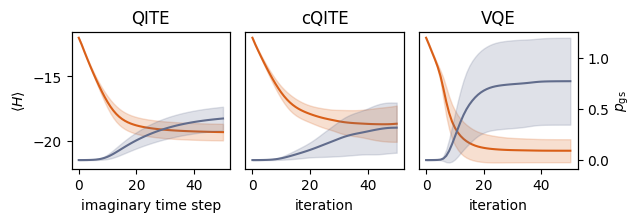

In [3]:
metrics = ['exp', 'opt']
x_labels = ['imaginary time step','iteration','iteration']
left_y_labels = [r'$\langle H \rangle$'] * 3
right_y_labels = [r'$p_{\text{gs}}$'] * 3
titles = ['QITE', 'cQITE', 'VQE']
colors = {'exp': custom_palette[-1] , 'opt': custom_palette[0]}
# Create the plots
fig = create_dual_axis_plots(iteration_progress, method_circuit_list, metrics, 
                             x_labels, left_y_labels, right_y_labels,
                             titles, colors, figsize=(6.6, 2.3))
plt.savefig('figs/curve1.svg', bbox_inches='tight')
plt.show()

## Plot curves for 3 cQITE instances

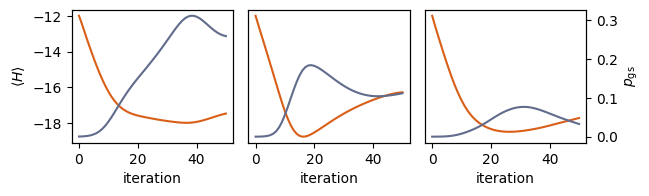

In [4]:
method_circuit = 'cQITE_P2A'
idx_list = [33,39,23]  # 按照idx的顺序排列
metrics = ['exp', 'opt']
x_labels = ['iteration','iteration','iteration']
left_y_labels = [r'$\langle H \rangle$'] * 3
right_y_labels = [r'$p_{\text{gs}}$'] * 3
titles = [None]*3
colors = {'exp': custom_palette[-1] , 'opt':custom_palette[0]}
# Create the plots
fig = create_dual_axis_plots_for_indices(
    iteration_progress, idx_list, method_circuit, 
    metrics, x_labels, left_y_labels, right_y_labels,
    titles, colors,figsize=(6.6, 2.25)
)
plt.savefig('figs/curve2.svg', bbox_inches='tight')
plt.show()

## QIV progress

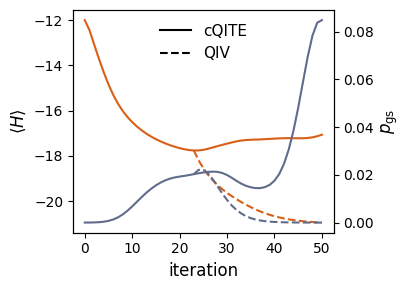

In [5]:
idx = 8 # another idx for illustration is 11
data_cQITE = json.load(open(f'results/cQITE_P2A/n16_reg3/{idx}.json'))
data_QIV = json.load(open(f'results/QIV_P2A/n16_reg3/{idx}.json'))
# Create figure and axes
fig = plt.figure(figsize=(4.2,3))
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
iters = len(data_cQITE['expectations'])
x = [i for i in range(iters)]
ax1.plot(x, data_cQITE['expectations'], label='cQITE_approx',color=custom_palette[-1])
ax2.plot(x, data_cQITE['opt_ratios'], label='cQITE_opt',color=custom_palette[0])
x = [i for i in range(data_cQITE['best_iter'],iters)]
ax1.plot(x,data_QIV['expectations'][1:],linestyle='--',color=custom_palette[-1])
ax2.plot(x,data_QIV['opt_ratios'][1:],linestyle='--',color=custom_palette[0])
ax1.set_xlabel('iteration',fontsize=12)
ax1.tick_params(axis='both', colors='black')
ax2.tick_params(axis='both', colors='black')
ax1.set_ylabel(r'$\langle H \rangle$', color='black',fontsize=12)
ax2.set_ylabel(r'$p_{\text{gs}}$', color='black',fontsize=12)
custom_lines = [
    Line2D([0], [0], color='black', linestyle='-'),
    Line2D([0], [0], color='black', linestyle='--')
]
ax1.legend(custom_lines, ['cQITE', 'QIV'], loc='upper center', fontsize=11, frameon=False)
plt.tight_layout()
plt.savefig(f'figs/qiv_progress_{idx}.svg',dpi=300)
plt.show()

# Plot results of 16-vertex 3-regular

read data from csv

In [6]:
n16_reg3_results = pd.read_csv('results/n16_reg3_results.csv')

## Plot approximate ratio results

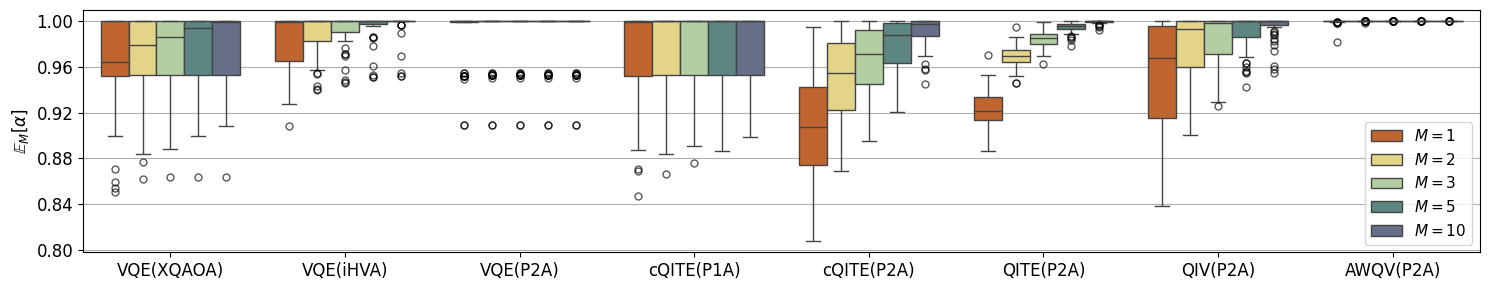

In [7]:
plt.figure(figsize=(15, 3))

# Filter data
data = n16_reg3_results[n16_reg3_results['metric'].isin(['AR1', 'AR2', 'AR3', 'AR5', 'AR10'])]
method_list = ['VQE_XQAOA', 'VQE_iHVA', 'VQE_P2A', 'cQITE_P1A', 'cQITE_P2A', 'QITE_P2A', 'QIV_P2A', 'AWQV_P2A']
data = data[data['method_circuit'].isin(method_list)]
data['method_circuit'] = pd.Categorical(data['method_circuit'], categories=method_list, ordered=True)

# Create the plot
sns.boxplot(
    data=data, x='method_circuit', y='value', hue='metric',
    flierprops=dict(
        marker='o', 
        markersize=5, 
        markeredgecolor=to_rgba('black', alpha=0.65)
    ),
    palette=custom_palette[::-1]
)

# Configure axes
plt.ylabel(r"$\mathbb{E}_M[\alpha]$", fontsize=12)
plt.xlabel(None)
plt.xticks(
    ticks=range(len(method_list)), 
    labels=['VQE(XQAOA)', 'VQE(iHVA)', 'VQE(P2A)', 'cQITE(P1A)', 'cQITE(P2A)', 'QITE(P2A)', 'QIV(P2A)', 'AWQV(P2A)'],
    fontsize=12
)
plt.yticks(ticks=np.arange(0.8, 1.0001, 0.04), fontsize=12)

# Customize legend
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['$M=1$', '$M=2$', '$M=3$', '$M=5$', '$M=10$']
plt.legend(
    handles=handles,
    labels=new_labels,
    title=None,
    fontsize=11,
    loc='lower right'  # Place in the lower right corner inside the plot
)

# Style settings
plt.grid(axis='y')
plt.tight_layout()

plt.savefig('figs/n16reg3_ars.svg')

plt.show()

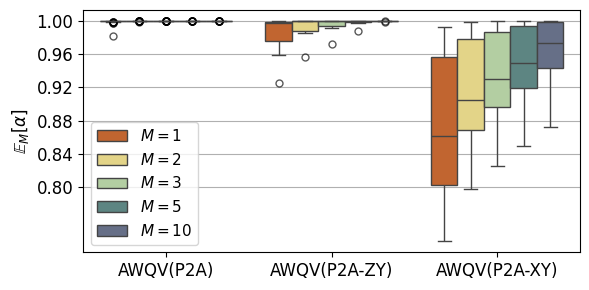

In [8]:
plt.figure(figsize=(6, 3))

# 过滤数据
data = n16_reg3_results[n16_reg3_results['metric'].isin(['AR1', 'AR2', 'AR3', 'AR5', 'AR10'])]
method_list = ['AWQV_P2A','AWQV_P2AZY','AWQV_P2AXY']
data = data[data['method_circuit'].isin(method_list)]
data['method_circuit'] = pd.Categorical(data['method_circuit'], categories=method_list, ordered=True)
sns.boxplot(
    data=data, x='method_circuit', y='value', hue='metric',
    flierprops=dict(
        marker='o', 
        markersize=5, 
        markeredgecolor=to_rgba('black', alpha=0.65)
    ),
    palette=custom_palette[::-1]
)
plt.ylabel(r"$\mathbb{E}_M[\alpha]$", fontsize=12)
plt.xlabel(None)
plt.xticks(
    ticks=range(len(method_list)), 
    labels=['AWQV(P2A)', 'AWQV(P2A-ZY)', 'AWQV(P2A-XY)'],
    fontsize=12
)
plt.yticks(ticks=np.arange(0.8, 1.0001, 0.04), fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['$M=1$', '$M=2$', '$M=3$', '$M=5$', '$M=10$']
plt.legend(
    handles=handles,
    labels=new_labels,
    title=None,
    fontsize=11,
    loc='lower left'  # 放回图内右上角
)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('figs/n16reg3_xyzy_ars.svg')
plt.show()

## Plot ground state probability results

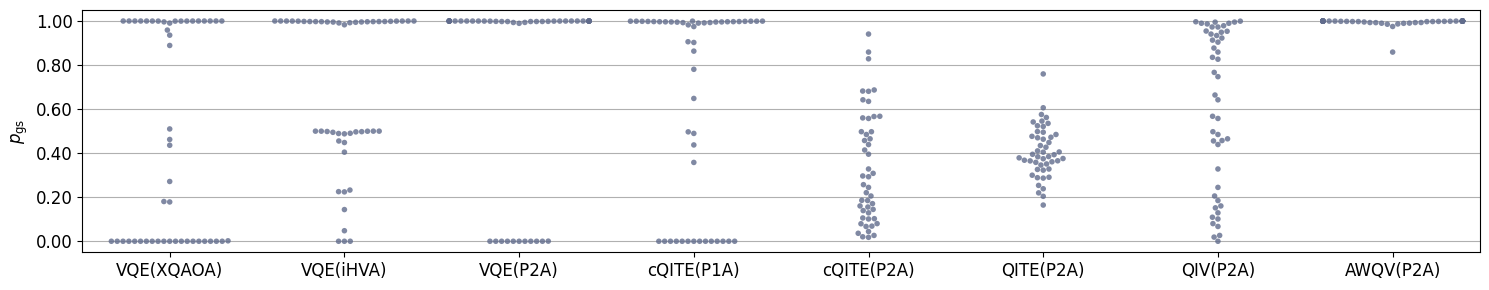

In [9]:
plt.figure(figsize=(15, 3))
data = n16_reg3_results[n16_reg3_results['metric'].isin(['opt'])]
method_list = ['VQE_XQAOA', 'VQE_iHVA', 'VQE_P2A', 'cQITE_P1A', 'cQITE_P2A', 'QITE_P2A', 'QIV_P2A', 'AWQV_P2A']
data = data[data['method_circuit'].isin(method_list)]
data['method_circuit'] = pd.Categorical(data['method_circuit'], categories=method_list, ordered=True)
sns.swarmplot(data=data, x='method_circuit', y='value', hue='metric', marker='o', size=4, alpha=0.8, palette=[custom_palette[0]])
plt.xlabel(None)
plt.ylabel(r"$p_{\text{gs}}$",fontsize=12)
plt.legend().remove()
plt.grid(axis='y')
plt.xticks(ticks=range(len(method_list)), 
           labels=['VQE(XQAOA)', 'VQE(iHVA)', 'VQE(P2A)', 'cQITE(P1A)', 'cQITE(P2A)', 'QITE(P2A)', 'QIV(P2A)', 'AWQV(P2A)'],
           fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))
plt.tight_layout()
plt.savefig('figs/n16reg3_pgs.svg')
plt.show()


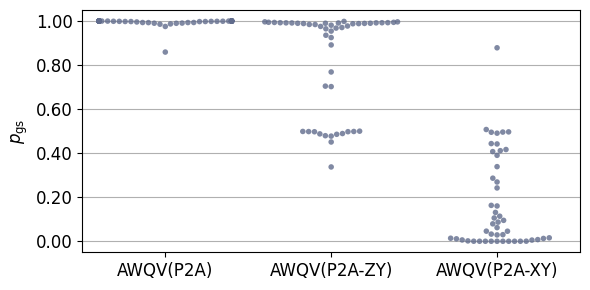

In [10]:
plt.figure(figsize=(6, 3))
data = n16_reg3_results[n16_reg3_results['metric'].isin(['opt'])]
method_list = ['AWQV_P2A','AWQV_P2AZY','AWQV_P2AXY']
data = data[data['method_circuit'].isin(method_list)]
data['method_circuit'] = pd.Categorical(data['method_circuit'], categories=method_list, ordered=True)
sns.swarmplot(data=data, x='method_circuit', y='value', hue='metric', marker='o', size=4, alpha=0.8, palette=[custom_palette[0]])
plt.xlabel(None)
plt.ylabel(r"$p_{\text{gs}}$",fontsize=12)
plt.legend().remove()
plt.grid(axis='y')
plt.xticks(ticks=range(len(method_list)), 
           labels=['AWQV(P2A)', 'AWQV(P2A-ZY)', 'AWQV(P2A-XY)'],
           fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))
plt.tight_layout()
plt.savefig('figs/n16reg3_xyzy_pgs.svg')
plt.show()

## Compare different optimizers for VQEs

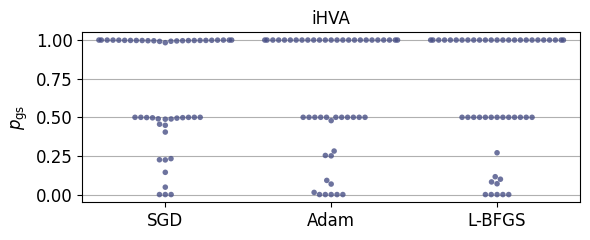

In [11]:
circuit = 'iHVA' # 'XQAOA' or 'iHVA' or 'P2A'

plt.figure(figsize=(6, 2.5))
data = n16_reg3_results[n16_reg3_results['metric'].isin(['opt'])]
method_list = [f'VQE_{circuit}',f'VQEAdam_{circuit}',f'VQELBFGS_{circuit}']
data = data[data['method_circuit'].isin(method_list)]
sns.swarmplot(data=data, x='method_circuit', y='value', hue='metric', marker='o', size=4, alpha=0.8, palette=['#495086'])
plt.xlabel(None)
plt.ylabel(r"$p_{\text{gs}}$",fontsize=12)
plt.legend().remove()
plt.grid(axis='y')
plt.xticks(ticks=range(3), 
           labels=['SGD', 'Adam', 'L-BFGS'],
           fontsize=12)
plt.yticks(ticks=np.arange(0, 1.0001, 0.25), fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))
plt.title(circuit,fontsize=12)
plt.tight_layout()
plt.savefig(f'figs/VQE_{circuit}_pgs.svg')
plt.show()

# Comparison on regular hraphs with different degress

read data from json

In [12]:
method_circuit_list = ['AWQV_P2AZY','VQE_iHVA','cQITE_P2AZY']

results = {'degree':[],'idx':[],'method_circuit':[],'opt':[]}
for d in range(3,11):
    for i in range(48):
        for method_circuit in method_circuit_list:
            path = f'results/{method_circuit}/n16_reg{d}/{i}.json'
            with open(path, 'r') as f:
                data = json.load(f)
                results['degree'].append(d)
                results['idx'].append(i)
                results['method_circuit'].append(method_circuit)
                results['opt'].append(data['opt_ratios'][data['best_iter']])

data = pd.DataFrame(results)

set color for each method

In [13]:
colors = {'AWQV_P2AZY': custom_palette[0], 'VQE_iHVA': custom_palette[-1] , 'cQITE_P2AZY': custom_palette[2]}

plot

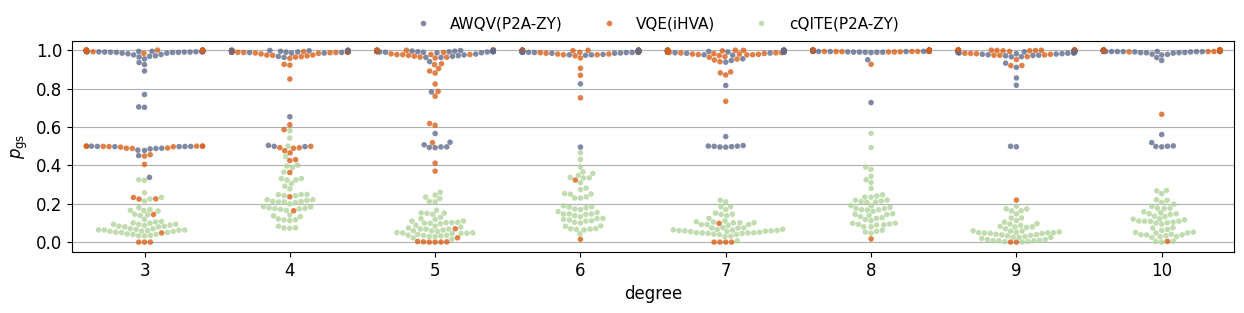

In [14]:
plt.figure(figsize=(15, 3.3))
sns.swarmplot(data=data, x='degree', y='opt', hue='method_circuit',dodge=False, marker='o', size=4, alpha=0.8, palette=colors)
plt.xlabel('degree', fontsize=12)
plt.ylabel(r'$p_{\text{gs}}$', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['AWQV(P2A-ZY)', 'VQE(iHVA)', 'cQITE(P2A-ZY)']
plt.legend(
    handles=handles,
    labels=new_labels,
    title=None,
    fontsize=11,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.98),
    ncol=3,
    frameon=False
)
plt.grid(axis='y')
plt.subplots_adjust(top=0.75)
plt.savefig('figs/reg_degree.svg',bbox_inches='tight')

In [15]:
print('mean/min results:')
print('AWQV_P2AZY:')
for d in range(3,11):
    print(np.round(np.mean(data[(data['method_circuit'] == 'AWQV_P2AZY')&(data['degree'] == d)]['opt']),3), np.round(min(data[(data['method_circuit'] == 'AWQV_P2AZY')&(data['degree'] == d)]['opt']),3))
print('VQE_iHVA:')
for d in range(3,11):
    print(np.round(np.mean(data[(data['method_circuit'] == 'VQE_iHVA')&(data['degree'] == d)]['opt']),3), np.round(min(data[(data['method_circuit'] == 'VQE_iHVA')&(data['degree'] == d)]['opt']),3))
print('cQITE_P2AZY:')
for d in range(3,11):
    print(np.round(np.mean(data[(data['method_circuit'] == 'cQITE_P2AZY')&(data['degree'] == d)]['opt']),3), np.round(min(data[(data['method_circuit'] == 'cQITE_P2AZY')&(data['degree'] == d)]['opt']),3)) 

mean/min results:
AWQV_P2AZY:
0.827 0.337
0.955 0.497
0.915 0.492
0.978 0.495
0.905 0.495
0.989 0.727
0.959 0.496
0.931 0.496
VQE_iHVA:
0.689 0.0
0.833 0.163
0.754 0.0
0.948 0.015
0.873 0.0
0.975 0.017
0.932 0.0
0.97 0.004
cQITE_P2AZY:
0.109 0.033
0.24 0.072
0.097 0.015
0.195 0.044
0.086 0.007
0.188 0.047
0.064 0.001
0.111 0.0


# Comparison on regular hraphs with different sizes

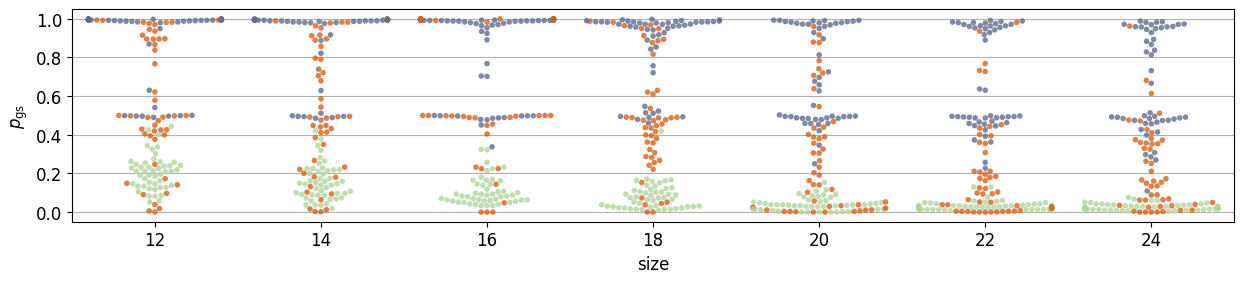

In [16]:
method_circuit_list = ['AWQV_P2AZY','VQE_iHVA','cQITE_P2AZY']

results = {'size':[],'idx':[],'method_circuit':[],'opt':[]}
for size in range(12,25,2):
    for i in range(48):
        for method_circuit in method_circuit_list:
            path = f'results/{method_circuit}/n{size}_reg3/{i}.json'
            with open(path, 'r') as f:
                data = json.load(f)
                results['size'].append(size)
                results['idx'].append(i)
                results['method_circuit'].append(method_circuit)
                results['opt'].append(data['opt_ratios'][data['best_iter']])

data = pd.DataFrame(results)

colors = {'AWQV_P2AZY': custom_palette[0], 'VQE_iHVA': custom_palette[-1] , 'cQITE_P2AZY': custom_palette[2]}

plt.figure(figsize=(15, 2.76))
sns.swarmplot(data=data, x='size', y='opt', hue='method_circuit',dodge=False, marker='o', size=4, alpha=0.8,palette=colors,legend=False)

plt.xlabel('size', fontsize=12)
plt.ylabel(r'$p_{\text{gs}}$', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y')
plt.savefig('figs/reg_size.svg',bbox_inches='tight')

In [17]:
print('mean/min results:')
print('AWQV_P2AZY:')
for s in range(12,25,2):
    print(np.round(np.mean(data[(data['method_circuit'] == 'AWQV_P2AZY')&(data['size'] == s)]['opt']),3), np.round(min(data[(data['method_circuit'] == 'AWQV_P2AZY')&(data['size'] == s)]['opt']),3))
print('VQE_iHVA:')
for s in range(12,25,2):
    print(np.round(np.mean(data[(data['method_circuit'] == 'VQE_iHVA')&(data['size'] == s)]['opt']),3), np.round(min(data[(data['method_circuit'] == 'VQE_iHVA')&(data['size'] == s)]['opt']),3))
print('cQITE_P2AZY:')
for s in range(12,25,2):
    print(np.round(np.mean(data[(data['method_circuit'] == 'cQITE_P2AZY')&(data['size'] == s)]['opt']),3), np.round(min(data[(data['method_circuit'] == 'cQITE_P2AZY')&(data['size'] == s)]['opt']),3)) 

mean/min results:
AWQV_P2AZY:
0.901 0.49
0.904 0.486
0.827 0.337
0.867 0.461
0.707 0.25
0.68 0.227
0.671 0.109
VQE_iHVA:
0.585 0.001
0.528 0.002
0.689 0.0
0.481 0.0
0.289 0.0
0.205 0.0
0.214 0.0
cQITE_P2AZY:
0.207 0.052
0.157 0.018
0.109 0.033
0.081 0.008
0.042 0.0
0.033 0.007
0.027 0.005


# Results on weighted graph

read data from json

In [18]:
results = {'graph':[],'idx':[],'opt':[]}
for p in range(1,10):
    for i in range(48):
        path = f'results/AWQV_P2AZY/n16_gnp{p}w/{i}.json'
        with open(path, 'r') as f:
            data = json.load(f)
            results['graph'].append(f'gnp{p}w')
            results['idx'].append(i)
            results['opt'].append(data['opt_ratios'][data['best_iter']])

data = pd.DataFrame(results)

## Plot ground state probability results

/var/folders/tk/yj66_jmd3cqb1847q586c6g40000gn/T/ipykernel_51762/1165323675.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, x='graph', y='opt', marker='o', size=4, alpha=0.8, palette=[(97/255, 108/255, 140/255)])


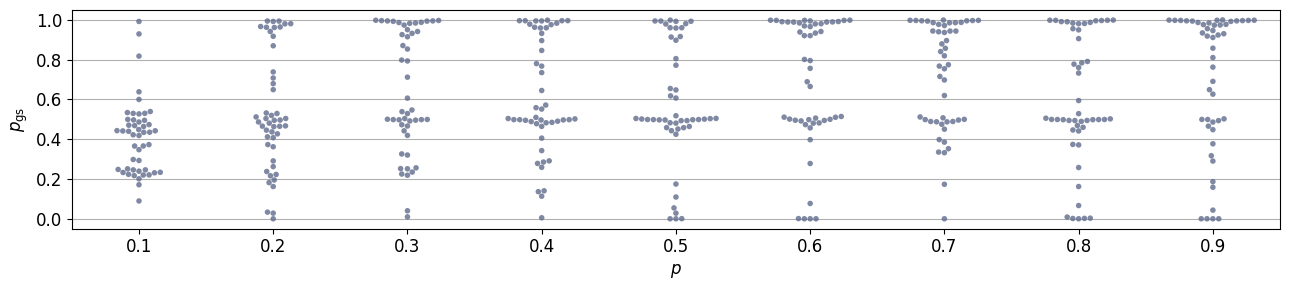

In [19]:
plt.figure(figsize=(13, 3))
sns.swarmplot(data=data, x='graph', y='opt', marker='o', size=4, alpha=0.8, palette=[(97/255, 108/255, 140/255)])
plt.xlabel(r"$p$",fontsize=12)
plt.ylabel(r"$p_{\text{gs}}$",fontsize=12)
plt.legend().remove()
plt.grid(axis='y')
plt.xticks(ticks=range(9), 
           labels=[i/10 for i in range(1,10)],
           fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}'))
plt.tight_layout()
plt.savefig('figs/pgs_gnpw.pdf')
plt.show()

## Compare to GW algorithm

read gw results from csv

In [20]:
gw_results = pd.read_csv(f'results/gw_results.csv')

In [21]:
AWQV_P2AZY = np.zeros((10,9))
for idx,shots in enumerate(range(5,51,5)):
    AWQV_P2AZY[idx] = [len(data[(data['opt'] < 1/shots) & (data['graph'] == f'gnp{p}w')]) for p in range(1,10)]

GW = np.zeros((10,9))
for idx,num in enumerate(range(5,51,5)):
    GW[idx] = [len(gw_results[(gw_results['optimal']==False) & (gw_results['graph']==f'gnp{p}w') & (gw_results['num_cuts']== num)]) for p in range(1,10)]

print(AWQV_P2AZY)
print(GW)
print(np.sum(AWQV_P2AZY, axis=1))
print(np.sum(GW, axis=1))

[[2. 6. 2. 4. 7. 5. 2. 7. 7.]
 [1. 3. 2. 1. 5. 5. 1. 6. 5.]
 [0. 3. 2. 1. 5. 4. 1. 6. 5.]
 [0. 3. 2. 1. 4. 4. 1. 5. 5.]
 [0. 3. 1. 1. 4. 4. 1. 5. 4.]
 [0. 2. 1. 1. 4. 4. 1. 5. 4.]
 [0. 2. 1. 1. 4. 4. 1. 5. 4.]
 [0. 1. 1. 1. 3. 4. 1. 5. 4.]
 [0. 1. 1. 1. 3. 4. 1. 5. 4.]
 [0. 1. 1. 1. 3. 4. 1. 5. 4.]]
[[ 5.  7.  8. 16. 20. 22. 15. 22. 17.]
 [ 3.  4.  6. 11.  7. 12.  3. 11.  9.]
 [ 2.  4.  5.  8.  7.  9.  3.  8.  6.]
 [ 2.  3.  5.  8.  6.  6.  3.  7.  5.]
 [ 2.  2.  5.  6.  4.  4.  3.  5.  3.]
 [ 2.  2.  5.  6.  4.  4.  3.  4.  3.]
 [ 2.  2.  5.  5.  4.  3.  3.  4.  1.]
 [ 2.  2.  5.  5.  4.  3.  3.  4.  1.]
 [ 2.  2.  5.  5.  4.  3.  3.  4.  1.]
 [ 2.  2.  5.  5.  4.  3.  3.  4.  1.]]
[42. 29. 27. 25. 23. 22. 22. 20. 20. 20.]
[132.  66.  52.  45.  34.  33.  29.  29.  29.  29.]


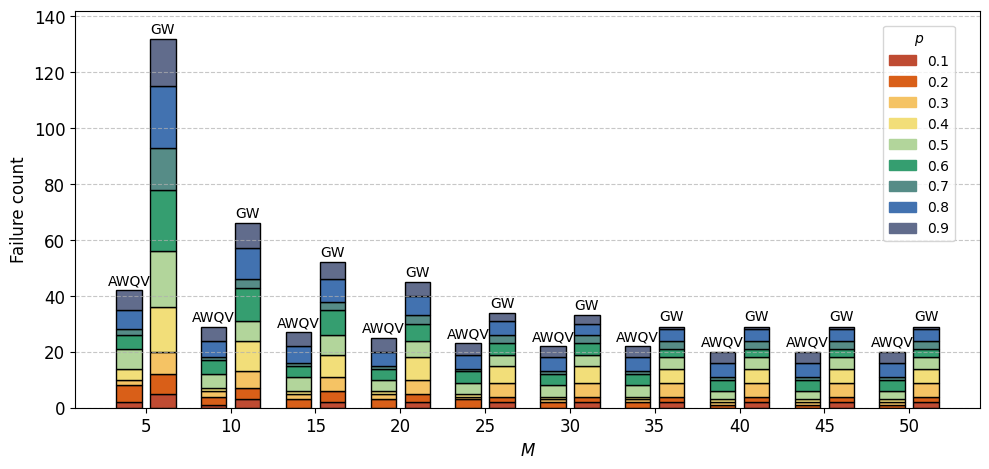

In [22]:
# Custom xtick labels
xtick_labels = [str(i) for i in range(5,51,5)]

# Plot parameters
bar_width = 0.3
group_gap = 0.1
x = np.arange(len(xtick_labels))

# Adjust bar positions
positions_A = x - bar_width/2 - group_gap/2
positions_B = x + bar_width/2 + group_gap/2

fig, ax = plt.subplots(figsize=(10, 4.8))

# Draw bar charts
for i in range(9):
    bottom_A = np.sum(AWQV_P2AZY[:, :i], axis=1) if i > 0 else np.zeros(10)
    bottom_B = np.sum(GW[:, :i], axis=1) if i > 0 else np.zeros(10)

    ax.bar(positions_A, AWQV_P2AZY[:, i], bar_width, bottom=bottom_A,
           color=custom_palette_2[i], edgecolor='black')

    ax.bar(positions_B, GW[:, i], bar_width, bottom=bottom_B,
           color=custom_palette_2[i], edgecolor='black')

# Axes and title
ax.set_xlabel('$M$', fontsize=12)
ax.set_ylabel('Failure count', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, fontsize=12)
ax.set_yticklabels(ax.get_yticks(), fontsize=12)
ax.set_ylim(0, max(GW.sum(axis=1).max(), AWQV_P2AZY.sum(axis=1).max()) + 10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Legend in the upper right corner inside the plot
handles = [plt.Rectangle((0,0),1,1, color=custom_palette_2[i]) for i in range(9)]
labels = [i/10 for i in range(1,10)]
ax.legend(handles, labels, title='$p$', loc='upper right', bbox_to_anchor=(0.98, 0.98), frameon=True)

# Add text labels above the bars
for idx in range(len(x)):
    ax.text(positions_A[idx], AWQV_P2AZY[idx].sum() + 1, 'AWQV', ha='center', va='bottom', fontsize=10)
    ax.text(positions_B[idx], GW[idx].sum() + 1, 'GW', ha='center', va='bottom', fontsize=10)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
plt.tight_layout()
plt.savefig('figs/failure_count.pdf')
plt.show()